# Binance

- Créér un clé API : https://www.binance.com/en/support/faq/360002502072
- **Quand elle est créée garder en mémoire l'api key et la secret KEY**

- créer un fichier config.cfg dans le même répertoire que le notebook et remplacer les valeurs par celles de l'API créée

```cfg
[BINANCE]
API_KEY = YOUR KEY                  
SECRET_KEY = YOUR SECRET KEY        
```



- installer le package python-binance 

```shell
pip install python-binance
ou
py -m pip install python-binance
ou autre
```
- Editer la list my_coins avec vos crypto 
```python
#exemple
my_coins = ['BTC','USDT', 'ETH']     # A ADAPTER
```

- Editer la monnaie de référence utilisée : USDT ou EUR
```python
#exemple
reference_asset = 'EUR'     # A ADAPTER
```

- et lancer tout les cellules


(Il peut y avoir des erreurs de désynchronisation d'horloge. Pour corriger cliquer sur l'heure, puis "paramètre date et heure", puis "synchroniser maintenant")


#### LISTE A COMPLETER

In [86]:
import requests, json, time, hashlib,hmac, configparser
import pandas as pd
import matplotlib.pyplot as plt
from binance import Client
# A ADAPTER 
#my_coins = ['BTC', 'ETH', 'ADA', 'DOT', 'MATIC', 'KSM', 'VET', 'SOL', 'BNB', 'CAKE', 'THETA', 'LTC', 'AVAX', 'DENT', 'EGLD', 'HOT', 'TRX', 'ONE', 'BAND', 'SXP','UTK', 'LINK', 'ATA', 'DOGE', 'MBOX', 'USDT' ]
my_coins = ['BTC', 'ETH', 'ADA', 'EUR']
reference_asset = 'EUR' # A ADAPTER USDT ou EUR

config = configparser.ConfigParser()
config.read_file(open('config_nils.cfg'))

KEY = config.get('BINANCE', 'API_KEY')
SECRET_KEY = config.get('BINANCE', 'SECRET_KEY')
BASE_URL = 'https://api.binance.com/'

client = Client(KEY, SECRET_KEY)


In [87]:
from urllib.parse import urlencode

# fonctions utilitaires

def get_timestamp():
    return int(time.time() * 1000)

def hashing(query_string):
    return hmac.new(SECRET_KEY.encode('utf-8'), query_string.encode('utf-8'), hashlib.sha256).hexdigest()

def dispatch_request(http_method):
    session = requests.Session()
    session.headers.update({
        'Content-Type': 'application/json;charset=utf-8',
        'X-MBX-APIKEY': KEY
    })
    return {
        'GET': session.get,
        'DELETE': session.delete,
        'PUT': session.put,
        'POST': session.post,
    }.get(http_method, 'GET')

def send_signed_request(http_method, url_path, payload={}):
    query_string = urlencode(payload, True)
    if query_string:
        query_string = "{}&timestamp={}".format(query_string, get_timestamp())
    else:
        query_string = 'timestamp={}'.format(get_timestamp())

    url = BASE_URL + url_path + '?' + query_string + '&signature=' + hashing(query_string)
    print("{} {}".format(http_method, url))
    params = {'url': url, 'params': {}}
    response = dispatch_request(http_method)(**params)
    return response.json()


In [88]:
# Create wallet
def create_wallet():
    wallet = {}
    for asset in my_coins:
        wallet[asset] = { 'Current_market_price':0, 'Current_value':0, 'Buy':0, 'Buy_price': 0, 'Buy_Qty':0, 'Sell':0, 'Sell_price': 0, 'Sell_Qty':0, 'Saving_value':0, 'Saving_Qty':0, 'Spot_value':0, 'Spot_Qty':0, 'Stack_value':0, 'Stack_Qty':0, 'ATH': 0, 'ATH_percent':0, 'Buy_price_percent':0, 'Balance':0}
    return wallet

In [89]:
# Les ordres disparus mystérieusement
## A compléter
mystere = {
    'BTC': {
        'mysterious_Qty': 0.001 + 0.002,    # Somme des quantités des ordres disparus
        'mysterious_Cost': 50 + 100       # Somme des coûts des ordres disparus
    },
    'ETH': {
        'mysterious_Qty': 0.1,    # Somme des quantités des ordres disparus
        'mysterious_Cost': 300       # Somme des coûts des ordres disparus
    }
}

In [90]:
# Get order history
def update_order_history(wallet, reference_asset, missing_orders = False):
    for asset in my_coins:
        symbol = asset + reference_asset
        if symbol != reference_asset + reference_asset :
            orders_history = client.get_all_orders(symbol=symbol)
            sum_coin = 0.0
            sum_cost = 0.0
            sell_coin = 0.0
            sell_cost = 0.0
            # add missing orders
            if missing_orders:
                try:
                    sum_coin += mystere[asset]['mysterious_Qty']
                    sum_cost += mystere[asset]['mysterious_Cost']
                except:
                    pass
            for order in orders_history:
                #print(asset, order['executedQty'], float(order['executedQty']) * float(order['price']))
                if order['side'] == 'BUY':
                    sum_cost += float(order['executedQty']) * float(order['price'])
                    sum_coin += float(order['executedQty']) 
                elif order['side'] == 'SELL':
                    sell_cost +=  float(order['executedQty']) * float(order['price'])
                    sell_coin += float(order['executedQty'])
            if sum_coin > wallet[asset]['Buy_Qty']:
                wallet[asset]['Buy_Qty'] = sum_coin 
                wallet[asset]['Buy_price'] = sum_cost / sum_coin
                wallet[asset]['Buy'] = sum_cost
                if sell_cost != 0:
                    wallet[asset]['Sell_Qty'] = sell_coin 
                    wallet[asset]['Sell_price'] = sell_cost / sell_coin
                    wallet[asset]['Sell'] = sell_cost

In [91]:
def update_market_price(wallet, reference_asset):
    all_coins = client.get_all_tickers()
    for asset in my_coins:
        if asset != reference_asset:
            for symbol in all_coins:
                if symbol['symbol'] == asset + reference_asset:
                    wallet[asset]['Current_market_price'] = float(symbol['price'])
        else:
            wallet[asset]['Current_market_price'] = 1

In [92]:
# Get current Savings
def update_saving(wallet):
    saving = send_signed_request('GET', 'sapi/v1/lending/union/account')
    savings = saving['positionAmountVos']
    for asset in savings:
        try :
            wallet[asset['asset']]["Saving_Qty"] = float(asset['amount'])
            wallet[asset['asset']]["Saving_value"] = float(asset['amount']) * wallet[asset['asset']]['Current_market_price']
            wallet[asset['asset']]["Saving_Qty"] = float(asset['amount'])
        except:
            pass

In [93]:
# stop value
def update_spot(wallet, reference_asset):
    spot = send_signed_request('GET', 'api/v3/account')

    for asset in my_coins:
        for asset_spot in spot["balances"]:
            if asset_spot['asset'] == asset:
                if asset != reference_asset:
                    wallet[asset]['Spot_value'] = wallet[asset]['Current_market_price'] * float(asset_spot['free'])
                    wallet[asset]['Spot_Qty'] = float(asset_spot['free'])
                else:
                    wallet[asset]['Spot_value'] = float(asset_spot['free'])

In [94]:
# get stacking value
def update_stacking(wallet):    
    ## Methode brut
    # A ADAPTER
    # stack = {'ADA':33.3+17.2+6.247+18.94+7.992+14.5+8.02,  'KSM':0.1599+0.24, 'MATIC':65+139.7+18, 'VET':497 , 'CAKE':1.785+4.06, 'SOL':0.5, 'DOT':9.556 , 'ETH':0.068836, 'BNB': 0.09388}
    # for asset in my_coins:
    #     try:
    #         coin = stack[asset]
    #         wallet[asset]['Stack_value'] = wallet[asset]['Current_market_price'] * coin
    #         wallet[asset]['Stack_Qty'] = stack[asset]
    #     except:
    #         pass

    ## Methode par déduction
    for asset in my_coins:
        if ( wallet[asset]['Saving_Qty'] + wallet[asset]['Spot_Qty'] ) < ( wallet[asset]['Buy_Qty'] - wallet[asset]['Sell_Qty']):
            wallet[asset]['Stack_Qty'] =  wallet[asset]['Buy_Qty'] - wallet[asset]['Saving_Qty'] - wallet[asset]['Spot_Qty'] - wallet[asset]['Sell_Qty']
            wallet[asset]['Stack_value'] = wallet[asset]['Current_market_price'] * wallet[asset]['Stack_Qty']

In [95]:
# balance calcul
def update_balance(wallet):
    for asset in my_coins:
        wallet[asset]["Balance"] =  int(wallet[asset]["Stack_value"] + wallet[asset]["Saving_value"] + wallet[asset]["Spot_value"] -  wallet[asset]["Buy"] + wallet[asset]["Sell"])

In [96]:
# Get ATH
def update_ath(wallet, reference_asset):
    for asset in my_coins:
        if asset != reference_asset:
            earliest_timestamp = client._get_earliest_valid_timestamp(asset + reference_asset, '1d')  # Here "ETHUSDT" is a trading pair and "1d" is time interval
            candle = client.get_historical_klines(asset + reference_asset, Client.KLINE_INTERVAL_1WEEK, "2 year ago UTC")
            max_asset = 0
            for c in candle:
                if float(c[2]) > max_asset:
                    max_asset = float(c[2])
            wallet[asset]['ATH'] = max_asset
            wallet[asset]['ATH_percent'] = str(int(wallet[asset]['Current_market_price'] * 100 // wallet[asset]['ATH'] ))+ " %"

In [97]:
def update_buy_price_percent(wallet):
    for asset in my_coins:
        if wallet[asset]['Current_market_price'] != 0:
            wallet[asset]['Buy_price_percent'] = str(100 - int(wallet[asset]['Buy_price'] * 100 // wallet[asset]['Current_market_price'])) + " %"

In [98]:
def update_current_value(wallet):
    for asset in my_coins:
        wallet[asset]['Current_value'] = wallet[asset]['Spot_value']  + wallet[asset]['Stack_value'] + wallet[asset]['Saving_value']
    if asset == reference_asset:
        wallet[asset]['Buy'] = wallet[asset]['Current_value']

In [99]:
def init(reference_asset):
    wallet = create_wallet()
    update_market_price(wallet, reference_asset)
    update_order_history(wallet, reference_asset, True)
    update_ath(wallet, reference_asset)
    return wallet


In [100]:
wallet = init(reference_asset)

In [101]:
def quick_update(wallet, reference_asset):
    update_market_price(wallet, reference_asset)
    update_saving(wallet)
    update_spot(wallet, reference_asset)
    update_stacking(wallet)
    update_balance(wallet)
    update_buy_price_percent(wallet)
    update_current_value(wallet)
    ## Si besoin de faire un export
    # with open("binance.json", "w") as outfile: 
    #     json.dump(wallet, outfile)
    return wallet

* *Current_market_price*: **prix actuel du marché**
* *Current_value*: **Valeur actuelle du portefeuille par asset**
* *Buy*: **Montant investit dans l'asset**
* *Buy_price*: **Valeur moyenne d'achat de l'asset**
* *Buy_Qty*: **Nombre total d'asset acheté**
* *Sell*: **Montant total de vente**
* *Sell_price*: **prix de vente**
* *Sell_Qty*: **Montant total d'asset vendu**
* *Saving_value*: **Valeur de l'asset en saving**
* *Saving_Qty*: **Quantité de l'asset en saving**
* *Spot_value*: **Valeur de l'asset en spot**
* *Spot_Qty*: **Quantité de l'asset en spot**
* *Stack_value*: **Valeur de l'asset en sacking**
* *Stack_Qty*: **Quantité de l'asset en sacking**
* *ATH*: **Valeur maximale atteinte par l'asset**
* *ATH_percent*: **Distance en pourcentage de l'ATH**
* *Buy_price_percent*: **Distance en pourcentage du prix d'achat moyen**
* *Balance*: **Plus ou moins value sur l'asset**

In [102]:
wallet = quick_update(wallet, reference_asset)
pd.DataFrame.from_dict(wallet,  orient='index')

GET https://api.binance.com/sapi/v1/lending/union/account?timestamp=1630667273756&signature=b2bfdf697428f12709d4eaee250690077cfbe3ae2bb542ae6ccee5b1842ba812
GET https://api.binance.com/api/v3/account?timestamp=1630667274074&signature=0ed6ce0670ab2b57976e037d02535a351f96dbc2b78740a63a7d80919f57e868


,Current_market_price,Current_value,Buy,Buy_price,Buy_Qty,Sell,Sell_price,Sell_Qty,Saving_value,Saving_Qty,Spot_value,Spot_Qty,Stack_value,Stack_Qty,ATH,ATH_percent,Buy_price_percent,Balance
BTC,42093.860,421.148648,245.664743,31499.518300,0.007799,0,0,0,421.148648,0.010005,0.000000,0.000000e+00,0.000000,0.000000,54296.810,77 %,26 %,175
ETH,3333.980,586.447082,443.274055,2520.034423,0.175900,0,0,0,430.577716,0.129148,0.002834,8.500000e-07,155.866532,0.046751,3620.850,92 %,25 %,143
ADA,2.505,56.638050,30.985913,1.370452,22.610000,0,0,0,0.342132,0.136580,0.000000,0.000000e+00,56.295918,22.473420,2.623,95 %,46 %,25
EUR,1.000,0.082657,0.082657,0.000000,0.000000,0,0,0,0.000000,0.000000,0.082657,0.000000e+00,0.000000,0.000000,0.000,0,100 %,0


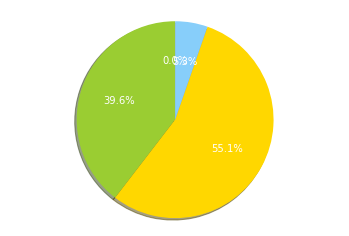

In [103]:
# Current repartition
sizes = [wallet[asset]['Spot_value'] + wallet[asset]['Saving_value'] + wallet[asset]['Stack_value'] for asset in  my_coins]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red', 'yellow', 'violet', 'black', 'pink', 'grey', 'blue', 'brown']
plt.figure()
plt.pie(sizes, labels = my_coins, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90, textprops={'color':"w"})
plt.axis('equal')
plt.show()

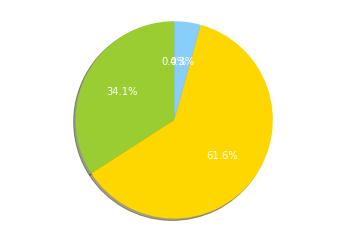

In [104]:
# Initial repartition
sizes = [wallet[asset]['Buy'] - wallet[asset]['Sell'] for asset in  my_coins]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red', 'yellow', 'violet', 'black', 'pink', 'grey', 'blue', 'brown']
plt.figure()
plt.pie(sizes, labels = my_coins, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90, textprops={'color':"w"})
plt.axis('equal')
plt.show()

In [105]:
## Bilan

# global balance
les_chiffres = {}
les_chiffres['current_value'] = 0
les_chiffres['total ' + reference_asset + ' invest'] = 0
les_chiffres['total_spot'] = 0
les_chiffres['total_saving'] = 0
les_chiffres['total_stacking'] = 0
les_chiffres['balance'] = 0
les_chiffres['plus-value'] = 0
les_chiffres['plus-value percent'] = 0

for asset in wallet:
    if asset != reference_asset:
        les_chiffres['balance'] += wallet[asset]['Balance']
        les_chiffres['total ' + reference_asset + ' invest'] +=  wallet[asset]['Buy']
        les_chiffres['total ' + reference_asset + ' invest'] -=  wallet[asset]['Sell']
        les_chiffres['total_spot'] += wallet[asset]['Spot_value']
        les_chiffres['total_saving'] += wallet[asset]['Saving_value']
        les_chiffres['total_stacking'] += wallet[asset]['Stack_value']
    else:
        les_chiffres['total ' + reference_asset + ' invest'] +=wallet[asset]['Balance']
        les_chiffres['total_spot'] += wallet[asset]['Spot_value']
        les_chiffres['total_saving'] += wallet[asset]['Saving_value']
        les_chiffres['total_stacking'] += wallet[asset]['Stack_value']

les_chiffres['current_value'] = les_chiffres['total_spot'] + les_chiffres['total_saving'] + les_chiffres['total_stacking']


les_chiffres['plus-value'] = les_chiffres['current_value'] - les_chiffres['total ' + reference_asset + ' invest']
les_chiffres['plus-value percent'] = (les_chiffres['current_value'] - les_chiffres['total ' + reference_asset + ' invest']) / les_chiffres['total ' + reference_asset + ' invest'] * 100

pd.DataFrame.from_dict(les_chiffres,  orient='index')

,0
current_value,1064.316437
total EUR invest,719.924711
total_spot,0.085490
total_saving,852.068496
total_stacking,212.162450
balance,343.000000
plus-value,344.391726
plus-value percent,47.837186


C:\Users\Thibaut - Eva\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  # This is added back by InteractiveShellApp.init_path()


<Figure size 720x720 with 0 Axes>

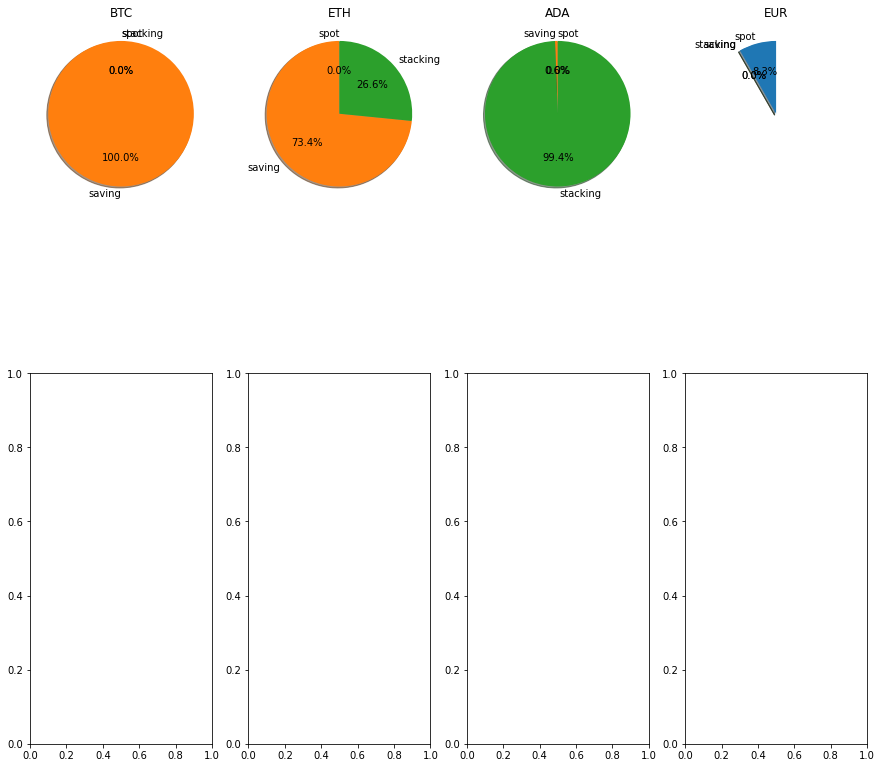

In [106]:
plt.figure(1, figsize=(10, 10))
chats_labels = my_coins
num_columns = 4                                
num_rows  = len(chats_labels) // 4 + 1
fig, ax = plt.subplots(num_rows,num_columns)
label = ['spot', 'saving', "stacking"]
for i, coin in enumerate(chats_labels):
    data = [wallet[coin]['Spot_value'], wallet[coin]['Saving_value'], wallet[coin]['Stack_value']]
    ax[i//4,i%4].set_title(coin)                           # Add 1 to j index
    ax[i//4,i%4].pie(data, labels=label,                 # Add 1 to j index
                autopct='%1.1f%%', shadow=True, startangle=90)
fig.set_size_inches(15,15)
plt.show()

In [107]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import IntProgress, widgets

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgba(c1))
    c2=np.array(mpl.colors.to_rgba(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='#FF4600'
c2='#3DD600' 

for asset in my_coins:
    value=wallet[asset]['Current_market_price']
    maxi=wallet[asset]['ATH']
    color = colorFader(c1,c2,mix=int(wallet[asset]['ATH_percent'][:2])/100)
    
    display(widgets.FloatProgress(
        value=value,
        min=0,
        max=maxi,
        description=asset,
        bar_style='success',
        style={'bar_color': color},
        orientation='horizontal',
    readout=True,
    readout_format='.1f',
    disabled=False
    ))
    
    display(widgets.HTML(
    value = asset + ": "+str(wallet[asset]['Current_market_price']) + ' / '+ str(wallet[asset]['ATH'])
    ))

FloatProgress(value=42093.86, bar_style='success', description='BTC', max=54296.81, style=ProgressStyle(bar_co…

HTML(value='BTC: 42093.86 / 54296.81')

FloatProgress(value=3333.98, bar_style='success', description='ETH', max=3620.85, style=ProgressStyle(bar_colo…

HTML(value='ETH: 3333.98 / 3620.85')

FloatProgress(value=2.505, bar_style='success', description='ADA', max=2.623, style=ProgressStyle(bar_color='#…

HTML(value='ADA: 2.505 / 2.623')

TypeError: 'int' object is not subscriptable